# Based on the original UCF101 dataset and InceptionV3 model

In [1]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

# Data preparation
___

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

print(f"Total videos for training: {len(train)}")
print(f"Total videos for testing: {len(test)}")

train.sample(10)

Total videos for training: 594
Total videos for testing: 224


,video_name,tag
72,v_CricketShot_g18_c04.avi,CricketShot
483,v_TennisSwing_g09_c01.avi,TennisSwing
438,v_ShavingBeard_g20_c03.avi,ShavingBeard
36,v_CricketShot_g13_c02.avi,CricketShot
347,v_Punch_g24_c03.avi,Punch
474,v_ShavingBeard_g25_c04.avi,ShavingBeard
390,v_ShavingBeard_g13_c01.avi,ShavingBeard
194,v_PlayingCello_g19_c04.avi,PlayingCello
107,v_CricketShot_g24_c04.avi,CricketShot
161,v_PlayingCello_g14_c03.avi,PlayingCello


### Video is a sequence of frames. Therefore each frame is extracted and put into a 3D tensor

In [3]:
IMG_SIZE = 224

In [4]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)

    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    
    try:
        while True:
            ret, frame = cap.read()
            
            if not ret:
                break
                
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
        
    return np.array(frames)

### Using pre-trained network to extract meaningful features from the extracted frames

In [5]:
feature_extractor = keras.applications.InceptionV3(
    weights="imagenet",
    include_top=False,
    pooling="avg",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)
    
preprocess_input = keras.applications.inception_v3.preprocess_input

inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
preprocessed = preprocess_input(inputs)

outputs = feature_extractor(preprocessed)

feature_extractor = keras.Model(inputs, outputs, name="feature_extractor")

### Set labels of videos as numbers by using StringLookup layer encoder

In [6]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train["tag"])
)

print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


### Data Processing utility

In [7]:
def prepare_all_videos(df, data_path):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    
    labels = df["tag"].values
    labels = label_processor(labels[:, None]).numpy()

    # `frame_masks` and `frame_features` will feed to our sequence model
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # Iterate for each video
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension
        frames = load_video(os.path.join(data_path, path))
        frames = frames[None, :]

        # Initialize placeholders to store the masks and features of the current video
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_featutes = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video
        for i, batch in enumerate(frames):
            video_length = batch.shape[1]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_featutes[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_featutes.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()


        return (frame_features, frame_masks), labels

In [8]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

train_data, train_labels = prepare_all_videos(train, "data/train")
test_data, test_labels = prepare_all_videos(test, "data/test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (594, 20, 2048)
Frame masks in train set: (594, 20)


# Modeling

In [9]:
class_vocab = label_processor.get_vocabulary()
frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

# GRU - recurrent model
#________________________
x = keras.layers.GRU(16, return_sequences=True)(
    frame_features_input, mask=mask_input
)
x = keras.layers.GRU(8)(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(8, activation="relu")(x)

output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

#________________________

rnn_model = keras.Model([frame_features_input, mask_input], output)

In [10]:
rnn_model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy"]
)

In [11]:
filepath = "data/tmp/video_classifier"
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath, 
    save_weights_only=True, 
    save_best_only=True, 
    verbose=1
)

In [12]:
BATCH_SIZE = 64
EPOCHS = 10

history = rnn_model.fit(
    [train_data[0], train_data[1]],
    train_labels,
    validation_split=0.3,
    epochs=EPOCHS,
    callbacks=[checkpoint],
)

rnn_model.load_weights(filepath)

Epoch 1/10
13/13 [==============================] - 12s 328ms/step - loss: 1.6052 - accuracy: 0.2723 - val_loss: 1.6244 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.62436, saving model to data/tmp/video_classifier
Epoch 2/10
13/13 [==============================] - 1s 99ms/step - loss: 1.5976 - accuracy: 0.2843 - val_loss: 1.6447 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss did not improve from 1.62436
Epoch 3/10
13/13 [==============================] - 1s 99ms/step - loss: 1.5893 - accuracy: 0.2819 - val_loss: 1.6674 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss did not improve from 1.62436
Epoch 4/10
13/13 [==============================] - 1s 101ms/step - loss: 1.5814 - accuracy: 0.2843 - val_loss: 1.6917 - val_accuracy: 0.0000e+00

Epoch 00004: val_loss did not improve from 1.62436
Epoch 5/10
13/13 [==============================] - 1s 99ms/step - loss: 1.5720 - accuracy: 0.2819 - val_loss: 1.7172 - val_accuracy: 0.0000e+00

Epoch 00005: val_los

In [13]:
_, accuracy = rnn_model.evaluate([test_data[0], test_data[1]], test_labels)

print(f"Test accuracy: {round(accuracy * 100, 2)}%")

7/7 [==============================] - 2s 19ms/step - loss: 1.6083 - accuracy: 0.2143
Test accuracy: 21.43%


# Usage

In [14]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_featutes = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[1]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_featutes[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_featutes, frame_mask

In [15]:
def prediction(video_path, print_all_labels = False):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(video_path)
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = rnn_model.predict([frame_features, frame_mask])[0]
    
    if print_all_labels:
        for i in np.argsort(probabilities)[::-1]:
            print(f"\t{class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    else:
        print(f"\t{class_vocab[0]}: {np.max(probabilities) * 100:5.2f}%")

    return frames

In [16]:
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)

    return embed.embed_file("animation.gif")

In [31]:
test_video_path = f"data/test/{np.random.choice(os.listdir('data/test/'))}"
test_video_path

'data/test/v_CricketShot_g06_c02.avi'

	CricketShot: 31.47%



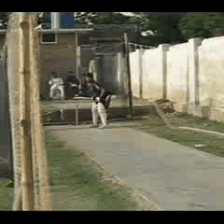

In [32]:
test_frames = prediction(test_video_path)

to_gif(test_frames[:MAX_SEQ_LENGTH])